In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(SeuratDisk)
    library(ggpubr)
    library(tictoc)
    library(future)
    library(ComplexHeatmap)
    library(circlize)
    library("Nebulosa")
})

o <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [2]:

load("t.cd8.annot.rda")

ls()


[1] "o"     "t.cd8"

In [3]:
t.cd8[["fineLabel"]]<-paste(t.cd8@meta.data$CD4CD8, t.cd8@meta.data$CD8sub, sep=" ")

In [5]:
library(paletteer)  
cl_levels = unique(t.cd8@meta.data$organ)
blockcol = paletteer_d("ggsci::default_igv")[1:length(cl_levels)] %>% as.vector
names(blockcol) <-cl_levels
blockcol

Lung    Pancreas       Blood       Liver      Muscle      Thymus 
"#5050FFFF" "#CE3D32FF" "#749B58FF" "#F0E685FF" "#466983FF" "#BA6338FF" 
    Jejunum      Rectum       Colon      Kidney Gallbladder     Stomach 
"#5DB1DDFF" "#802268FF" "#6BD76BFF" "#D595A7FF" "#924822FF" "#837B8DFF" 
     Vessel     Thyroid   Intestine      Spleen Bone marrow         Eye 
"#C75127FF" "#D58F5CFF" "#7A65A5FF" "#E4AF69FF" "#3B1B53FF" "#CDDEB7FF"

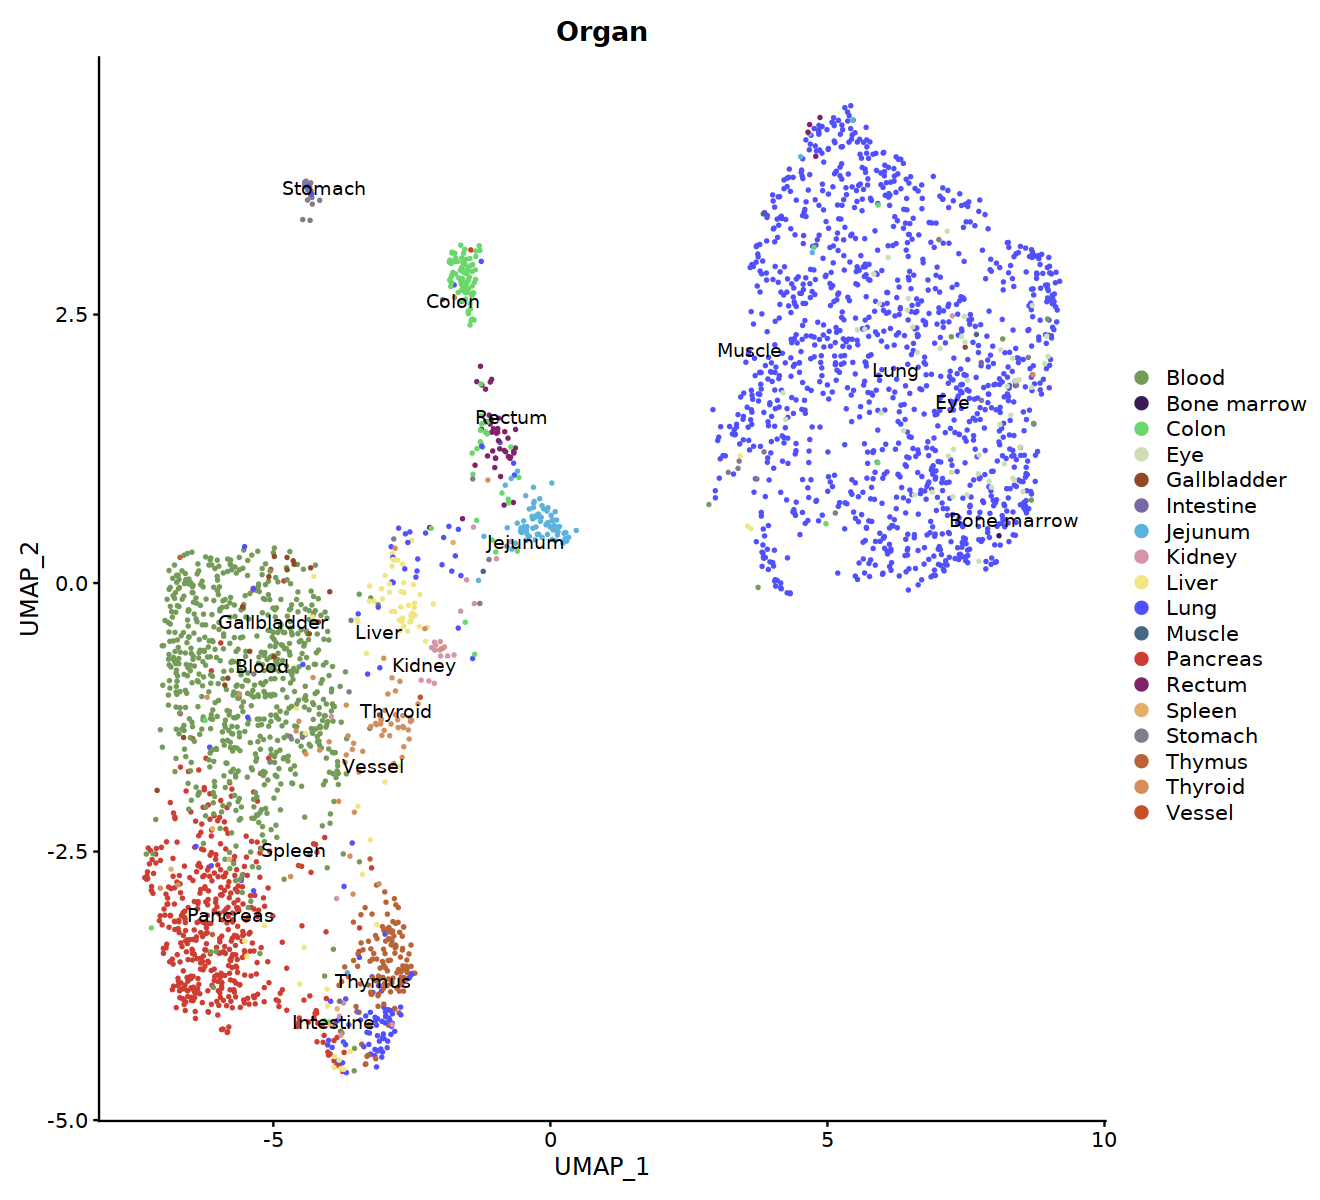

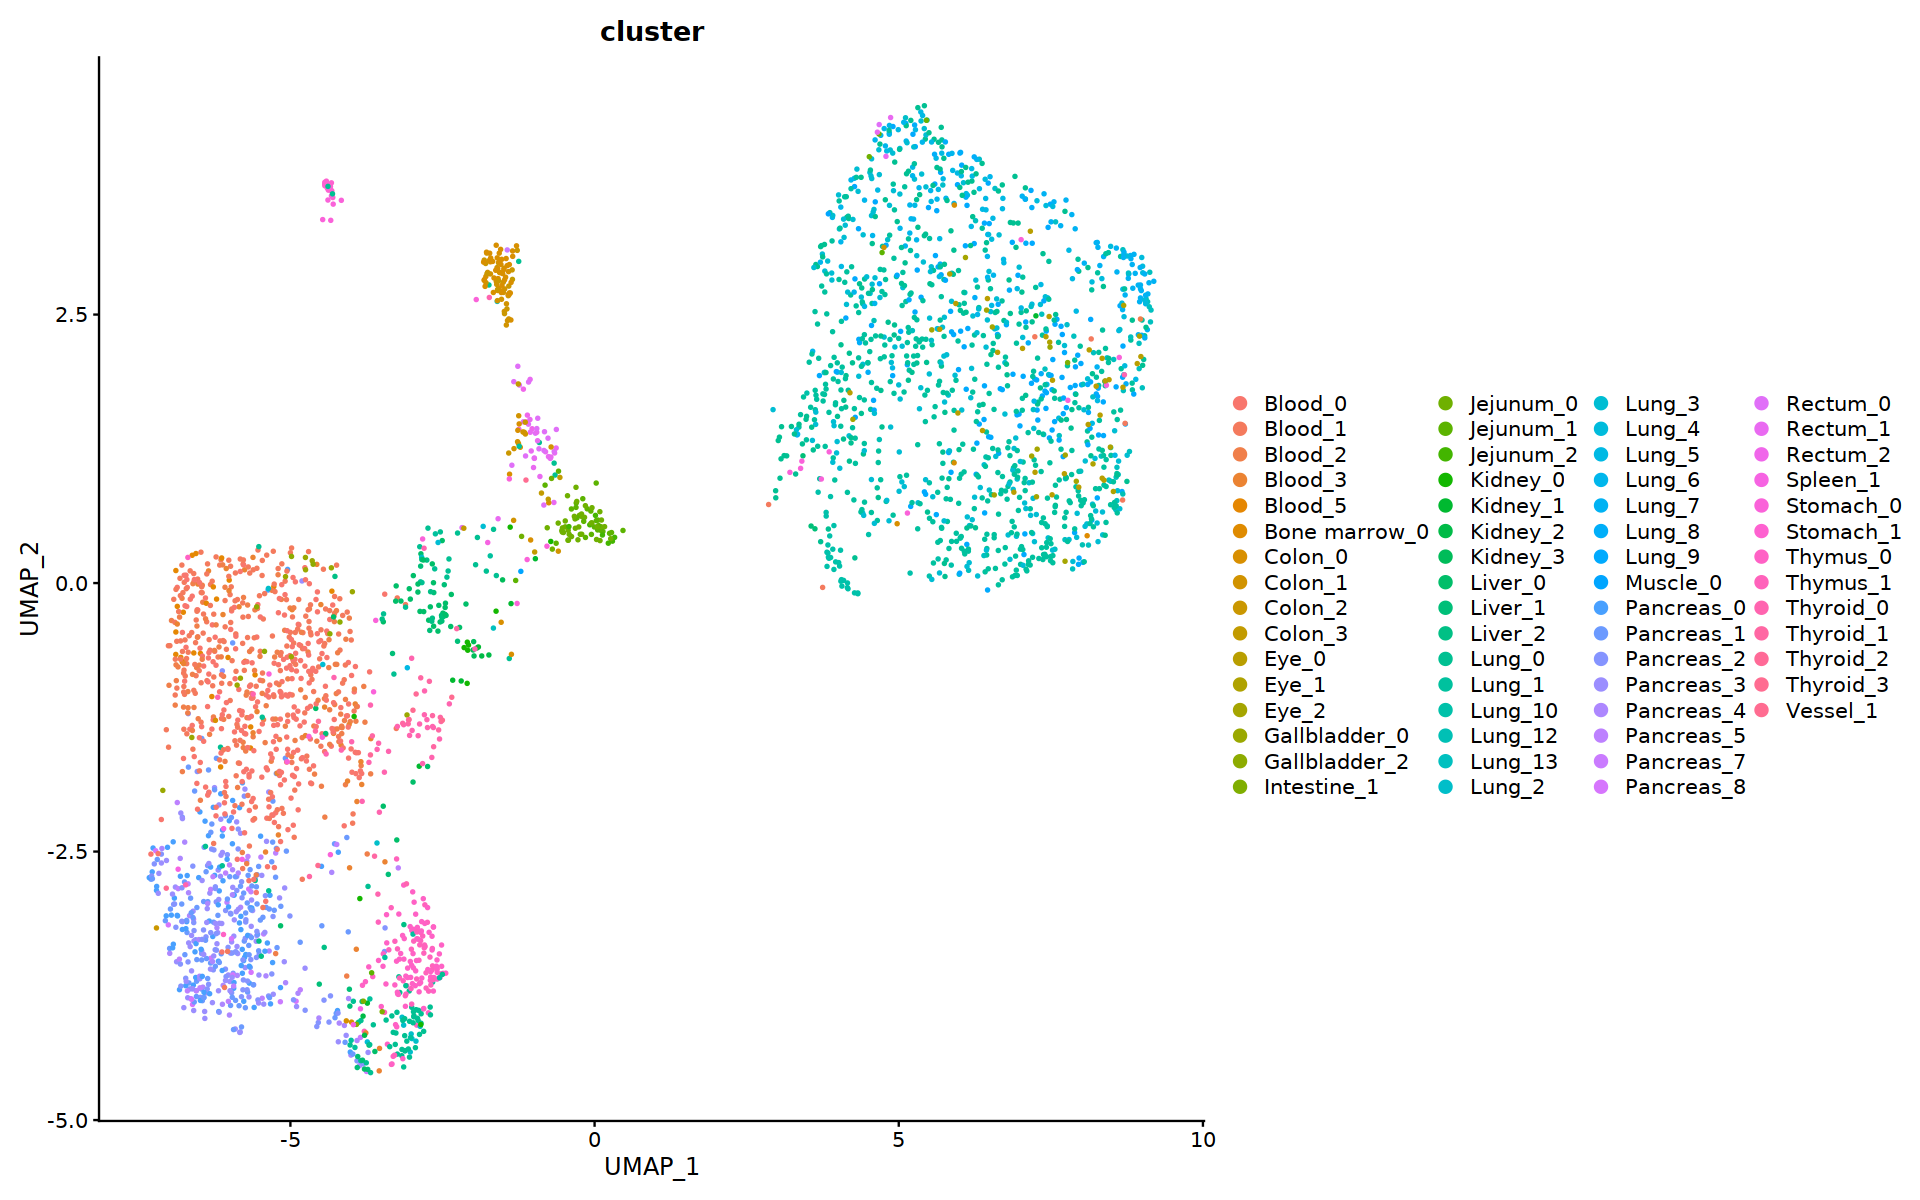

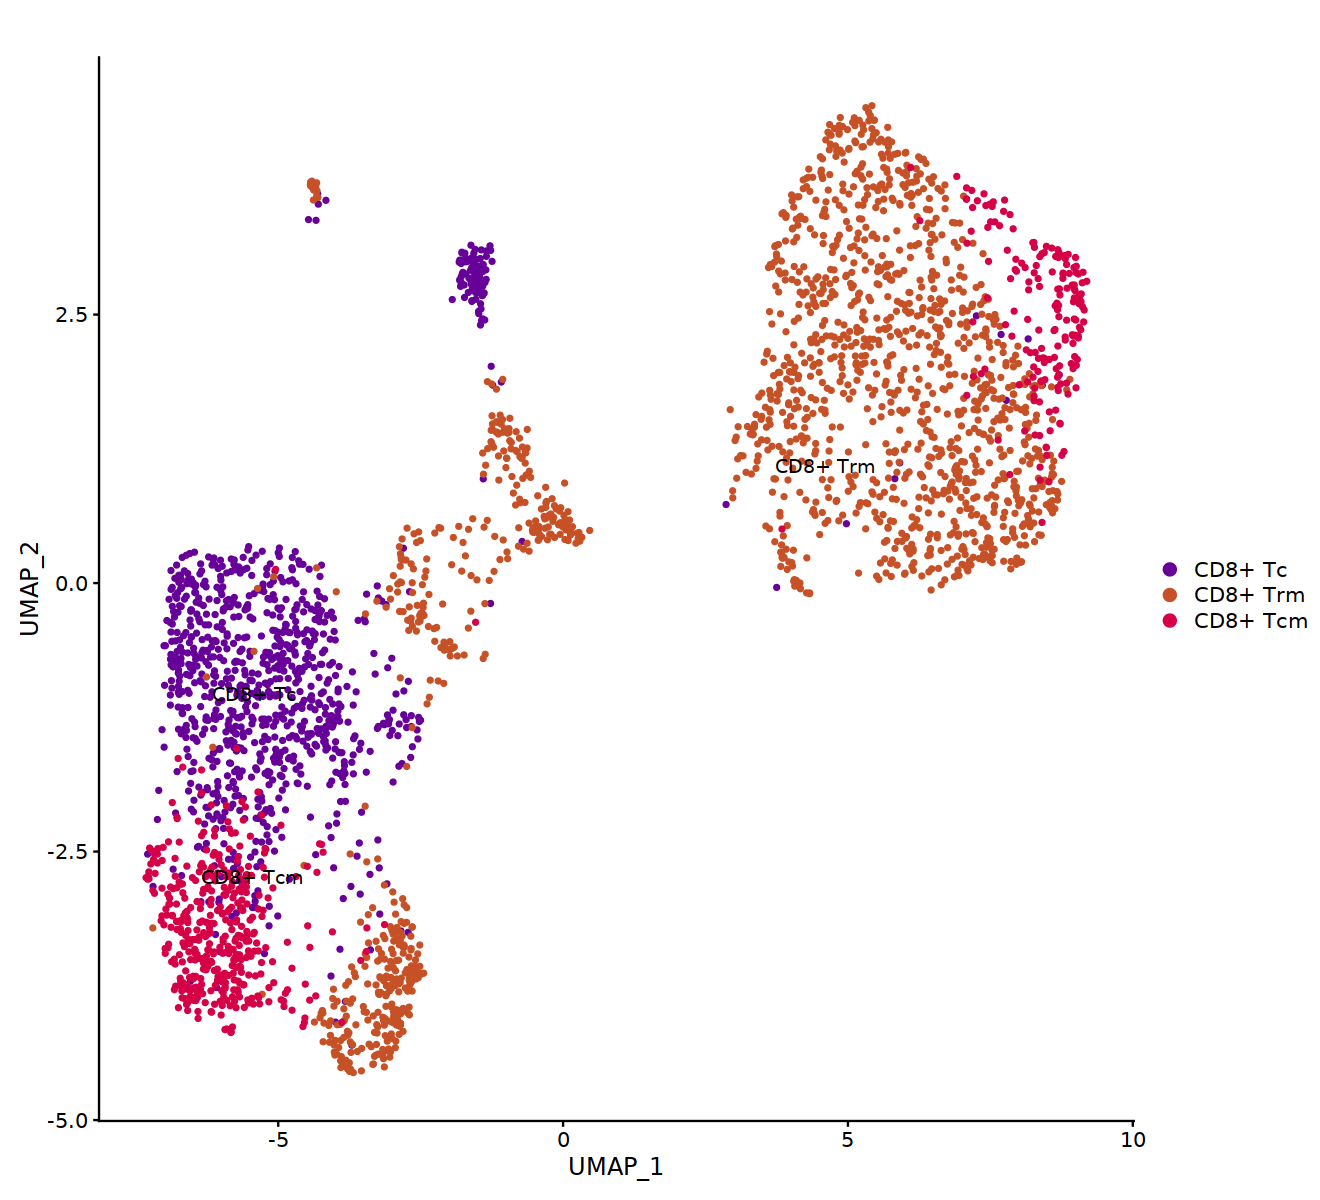

In [7]:
o(11,10)
DimPlot(t.cd8, group.by="organ", cols=blockcol, label=T,repel=T)+ggtitle("Organ")
o(16,10)
DimPlot(t.cd8, group.by="cluster")
o(10,10)
#DimPlot(subset(seu, fineLabel!="DN T"), group.by="fineLabel")
#DimPlot(subset(seu, fineLabel!="DN T"), group.by="CD4CD8")

o(11,10)
DimPlot(t.cd8, group.by="fineLabel", pt.size=1,
order=c( 'CD4+ Tcm',  'CD4+ Tem',  'CD4+ Th1',  'CD8+ Tcm',  'CD8+ Trm',  'CD8+ Tc','DN T' ),
cols = c('CD4+ Tcm'='#5DB1DDFF',
  'CD4+ Tem'='#009966FF',
  'CD4+ Th1'='#00CC33FF',
  'CD8+ Tcm'='#D60047FF',
  'CD8+ Trm'='#C75127FF',
  'CD8+ Tc' ='#660099FF',
  
  'DN T'    ='#A9A9A933'), label=T,repel=T)+ggtitle("")

# load metabolic genesets

In [8]:
library(AUCell)
library(GSVA)
library(GSEABase)
kegg.metabo <- getGmt("./KEGG_metabolism.gmt")
kegg.metabo.list = list()

for (i in 1:length(kegg.metabo)){
    gs_name=kegg.metabo[[i]]@setName
    gs_contents= kegg.metabo[[i]]@geneIds
    
    kegg.metabo.list[[gs_name]]=gs_contents
}

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required p

# construct per-cluster  objects

## per-cluster RNA objects

In [12]:
Idents(t.cd8) <- "cluster"
t.cd8.avg <- AverageExpression(t.cd8, assays = "RNA", slot = "data", return.seurat=T)

Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix



In [84]:
t.cd8.avg@assays$RNA@data

,Lung_13,Lung_10,Lung_3,Lung_8,Lung_1,Lung_5,Lung_9,Lung_7,Lung_0,Lung_4,⋯,Thyroid_0,Thyroid_1,Intestine_1,Spleen_1,Bone marrow_0,Eye_0,Eye_2,Eye_1,Thyroid_3,Thyroid_2
A1BG,0.16853248,0.22507653,0.17788690,0.2359628,0.13450829,0.32019926,0.35867566,0.55838230,0.07261482,0.6207734,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.62067694,0.27638850,0.3960897,0,0
A1BG-AS1,0.27785193,0.00000000,0.05508067,0.2182440,0.04421700,0.00000000,0.03461319,0.00000000,0.06552333,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.00000000,0.00000000,0.0000000,0,0
A2M,0.22734398,0.14267545,0.15260527,0.1604071,0.09580792,0.29629797,0.07578018,0.00000000,0.40118453,0.0000000,⋯,0.4820239,1.1079520,2.176171,0.000000,0,0.00000000,0.00000000,0.0000000,0,0
A2M-AS1,0.09124090,0.17702701,0.20661679,0.1593848,0.22358177,0.08314922,0.24628807,0.00000000,0.19899622,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.25435516,0.27433583,0.0000000,0,0
A2ML1,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.00000000,0.00000000,0.0000000,0,0
A4GALT,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.05171783,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.00000000,0.00000000,0.0000000,0,0
A4GNT,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.00000000,0.00000000,0.0000000,0,0
AAAS,0.00000000,0.32790243,0.10566695,0.3271242,0.21777654,0.00000000,0.12649427,0.11778145,0.26153587,0.0000000,⋯,0.5424717,0.0000000,2.034567,1.249203,0,0.08359782,0.00000000,0.0000000,0,0
AACS,0.00000000,0.00000000,0.00000000,0.2182440,0.02559341,0.11095658,0.04536681,0.00000000,0.01877327,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.20899083,0.00000000,0.1713347,0,0
AADAC,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0.000000,0.000000,0,0.00000000,0.00000000,0.0000000,0,0


## per-cluster metabolism object

In [24]:
CreateGenesetScoreObject <- function(seu, gs.list, method, ...){
    if (method=="GSVA"){
        library(GSVA)
        gs.scores <- GSVA::gsva(expr=as.matrix(seu@assays$RNA@data), 
                                gset.idx.list = gs.list)
        gsva.seu <- CreateSeuratObject(counts = gs.scores[,rownames(seu@meta.data)], 
                    assay = "GSVA",
                    meta.data = seu@meta.data)
        
        gsva.seu@assays$GSVA@counts <- as.matrix(gsva.seu@assays$GSVA@counts)
        gsva.seu@assays$GSVA@data   <- as.matrix(gsva.seu@assays$GSVA@data)
        gsva.seu <- ScaleData(gsva.seu, assay="GSVA", do.scale=TRUE , do.center=TRUE)
        return(gsva.seu)
    }else if (method=="AUCell"){
        library(AUCell)
        cells_rankings <- AUCell_buildRankings(as.matrix(seu@assays$RNA@data))
        gs.scores <- AUCell_calcAUC(gs.list, cells_rankings, aucMaxRank=nrow(cells_rankings)*0.1)
        gs.scores <- getAUC(gs.scores)
        auc.seu <- CreateSeuratObject(counts = gs.scores[,rownames(seu@meta.data)], 
                    assay = "AUCell",
                    meta.data = seu@meta.data)
        
        auc.seu@assays$AUCell@counts <- as.matrix(auc.seu@assays$AUCell@counts)
        auc.seu@assays$AUCell@data   <- as.matrix(auc.seu@assays$AUCell@data)
        auc.seu <- ScaleData(auc.seu, assay="AUCell", do.scale=TRUE , do.center=TRUE)
        return(auc.seu)
    }else{
        message("undefined method")
        return
    }
    
}

In [25]:
t.cd8.avg.metabo<-CreateGenesetScoreObject(t.cd8.avg, gs.list =kegg.metabo.list, method="GSVA" )

Warning message in .filterFeatures(expr, method):
“27659 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 83 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix



In [26]:
t.cd8.avg.metabo

An object of class Seurat 
83 features across 61 samples within 1 assay 
Active assay: GSVA (83 features, 0 variable features)

# Metabolic clustering

In [95]:
# 1.1 收集表达矩阵
mat  = t.cd8.avg.metabo@assays$GSVA@scale.data

# 1.2 把细胞按某种想要的顺序排好
ordered.cells <- colnames(mat)

# 1.3 选择一列感兴趣的基因用于绘图
t.cd8.avg.metabo<-FindVariableFeatures(t.cd8.avg.metabo,nfeatures = 20)
features.sel <-  VariableFeatures(t.cd8.avg.metabo) #rownames(mat)

# 1.4 重新组织原始矩阵按行列
mat = as.matrix( mat[features.sel, ordered.cells] )

In [96]:
meta = t.cd8.avg.metabo@meta.data

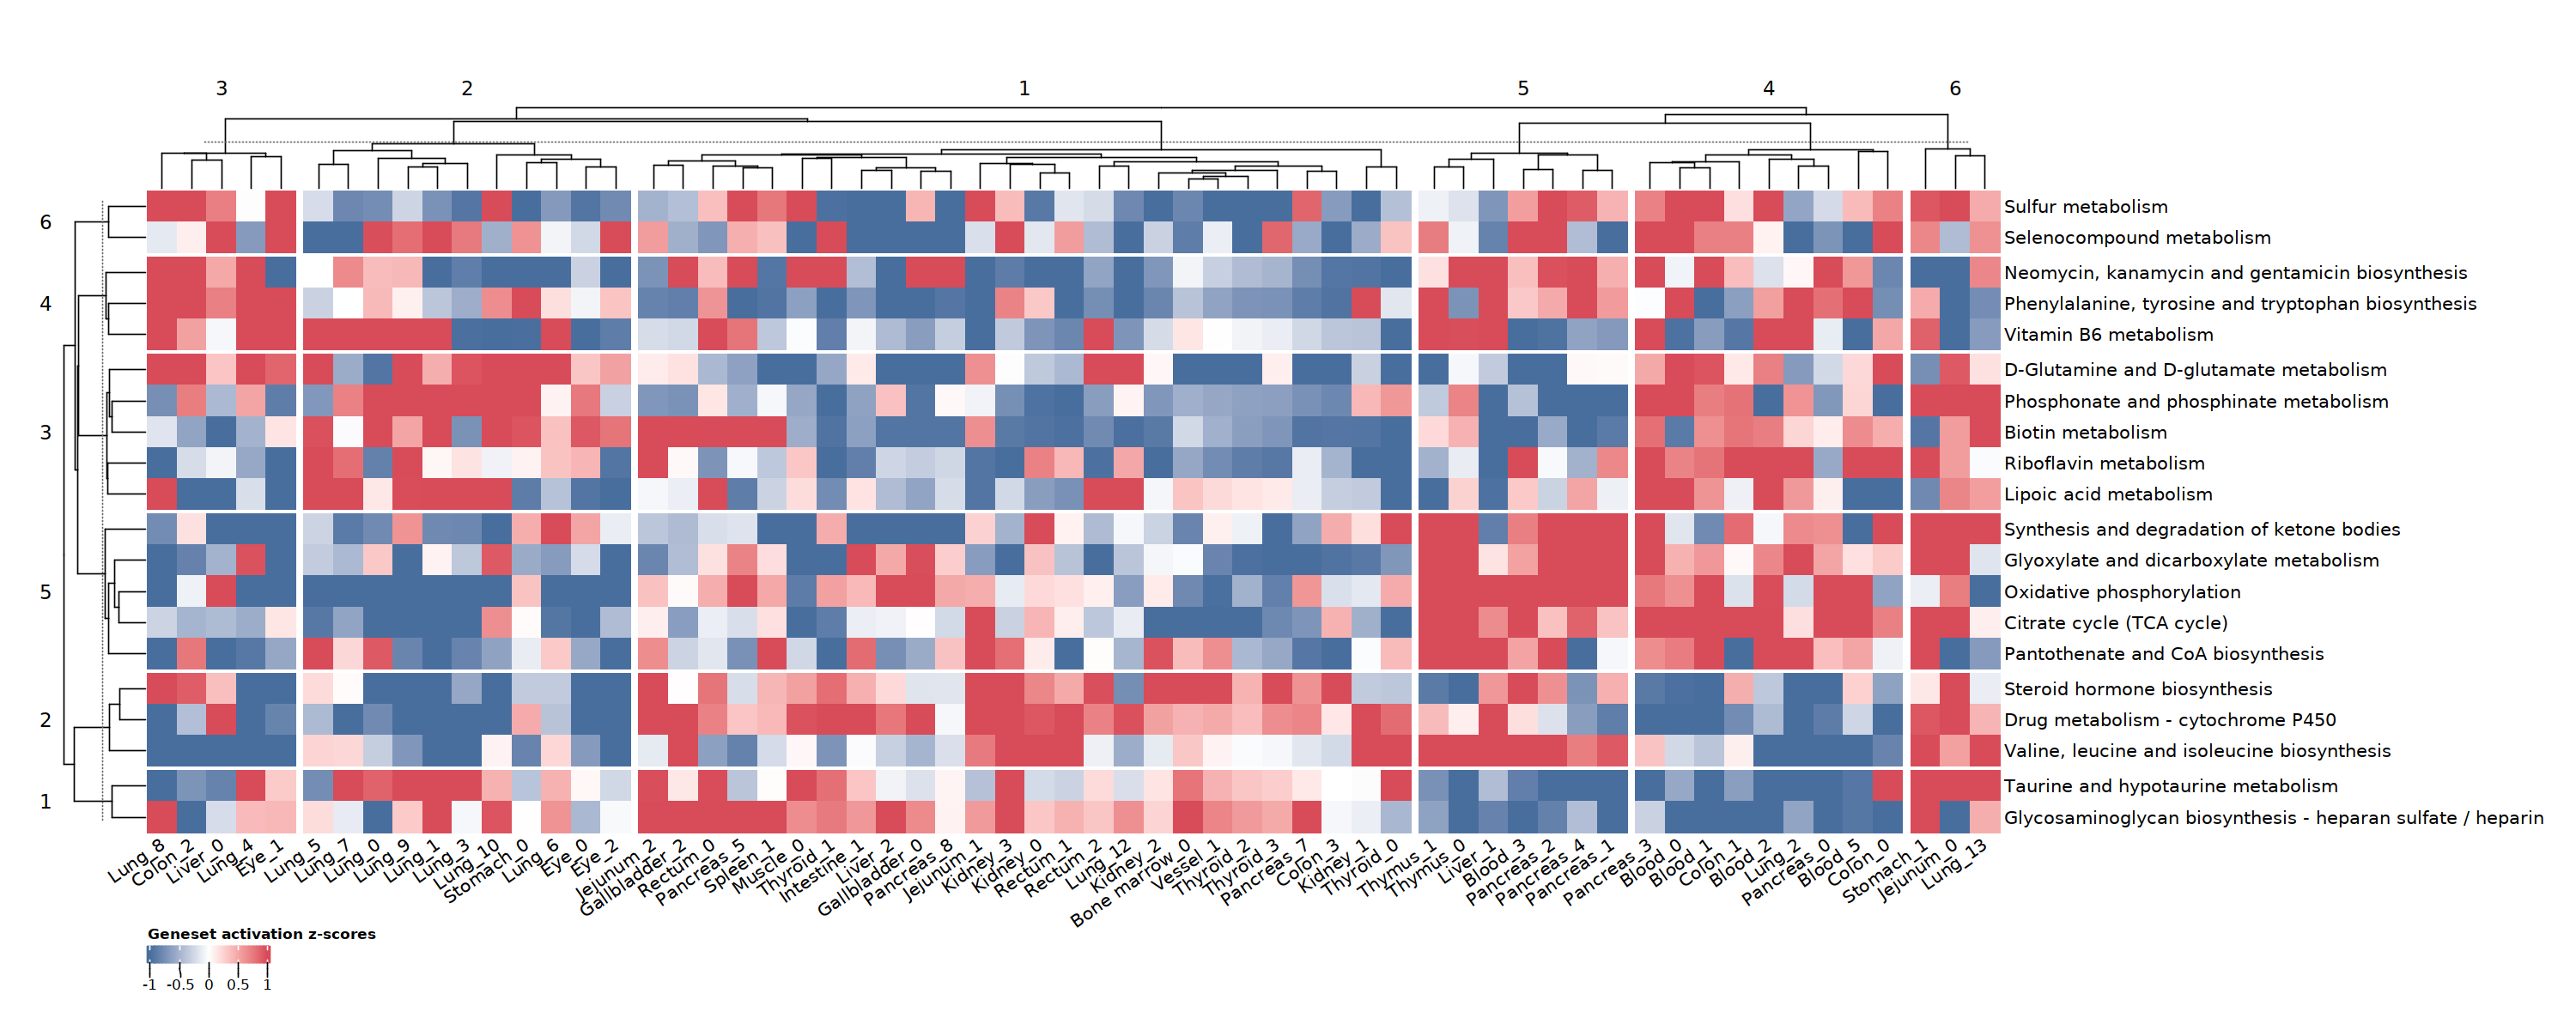

In [186]:
hm<-Heatmap(mat, name = "Geneset activation z-scores", 
        cluster_rows = T, cluster_columns = T, 
        show_column_names=T,
        column_dend_height = unit(2, "cm"), row_dend_width=unit(2,'cm'),
        row_km=6, column_km=6, column_km_repeats=100,row_km_repeats=100,
        cluster_column_slices=T, cluster_row_slices=T,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-1,0,1), c("#486E9E", "white", "#D84B59")),
        column_title_rot=0, row_title_rot=0, 
        column_names_rot =35,
        column_gap=unit(2, "mm"),
        #top_annotation=colann, 
        heatmap_legend_param = list(direction = "horizontal"),
        use_raster = F)

options(warn=-1)
options(repr.plot.width=25, repr.plot.height=10)
#cairo_pdf("t.metabo.hm.pdf",width=25, height = 20)
draw(hm,
     padding = unit(c(10, 10, 20, 80), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
#dev.off()

In [194]:
hm<-Heatmap(mat, name = "Geneset activation z-scores", 
        cluster_rows = T, cluster_columns = T, 
        show_column_names=T,
        column_dend_height = unit(2, "cm"), row_dend_width=unit(2,'cm'),
        row_km=6, column_km=6, column_km_repeats=100,row_km_repeats=100,
        cluster_column_slices=T, cluster_row_slices=T,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-1,0,1), c("#486E9E", "white", "#D84B59")),
        column_title_rot=0, row_title_rot=0, 
        column_names_rot =35,
        column_gap=unit(2, "mm"),
        #top_annotation=colann, 
        heatmap_legend_param = list(direction = "horizontal"),
        use_raster = F)

options(warn=-1)
options(repr.plot.width=25, repr.plot.height=10)
cairo_pdf("CD8T.metabo.per-cluster-hm.pdf",width=25, height = 10)
draw(hm,
     padding = unit(c(10, 10, 20, 80), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

png 
  2

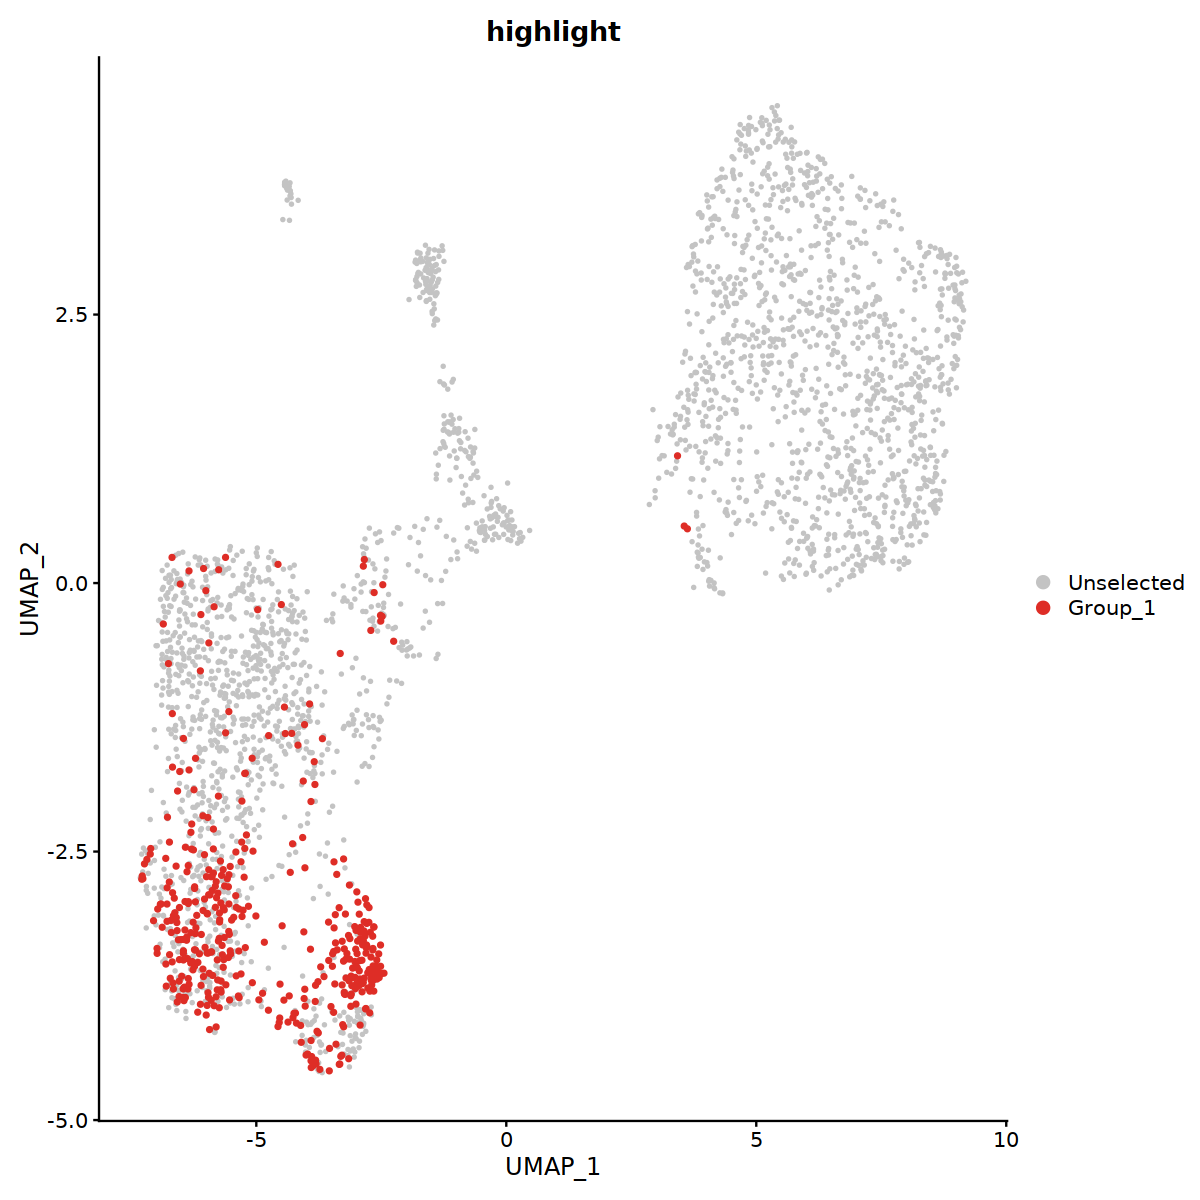

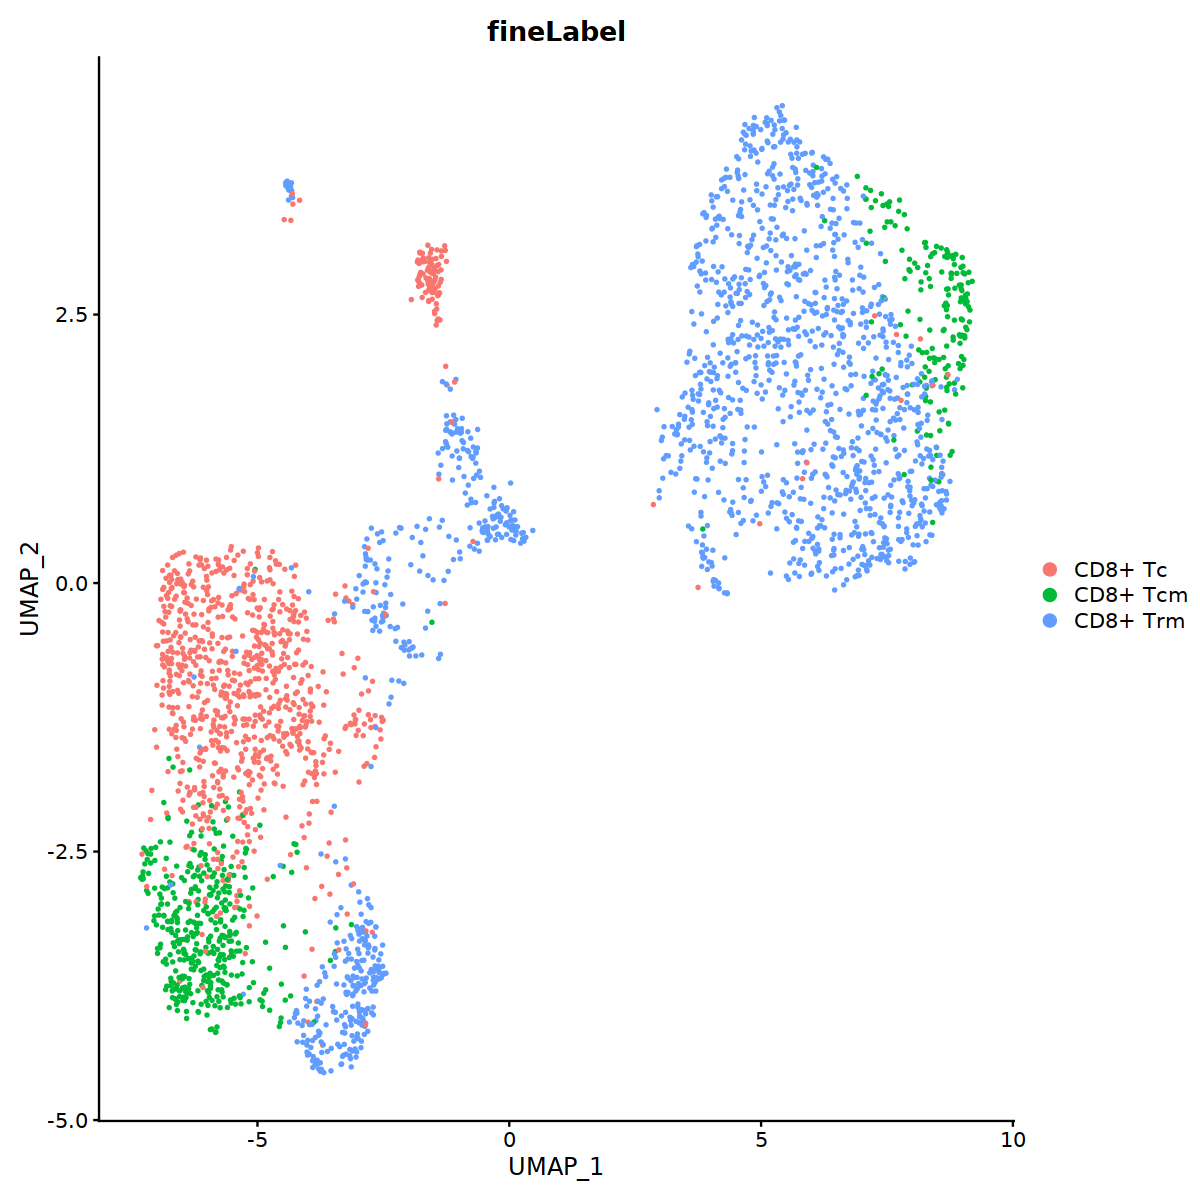

In [193]:
clusters.oi <- colnames(mat)[column_order(hm)[["6"]]]

o(10,10)
Idents(t.cd8 )<-"cluster"
DimPlot(t.cd8, group.by="cluster",
        cells.highlight=WhichCells(t.cd8, ident=clusters.oi))

DimPlot(t.cd8, group.by="fineLabel")

In [180]:
clusters.oi

[1] "Stomach_1"  "Jejunum_0"  "Blood_3"    "Pancreas_2" "Thymus_1"  
 [6] "Thymus_0"   "Pancreas_4" "Pancreas_1" "Pancreas_3" "Blood_0"   
[11] "Blood_1"    "Colon_1"    "Blood_2"    "Lung_2"     "Pancreas_0"
[16] "Colon_2"    "Blood_5"    "Colon_0"

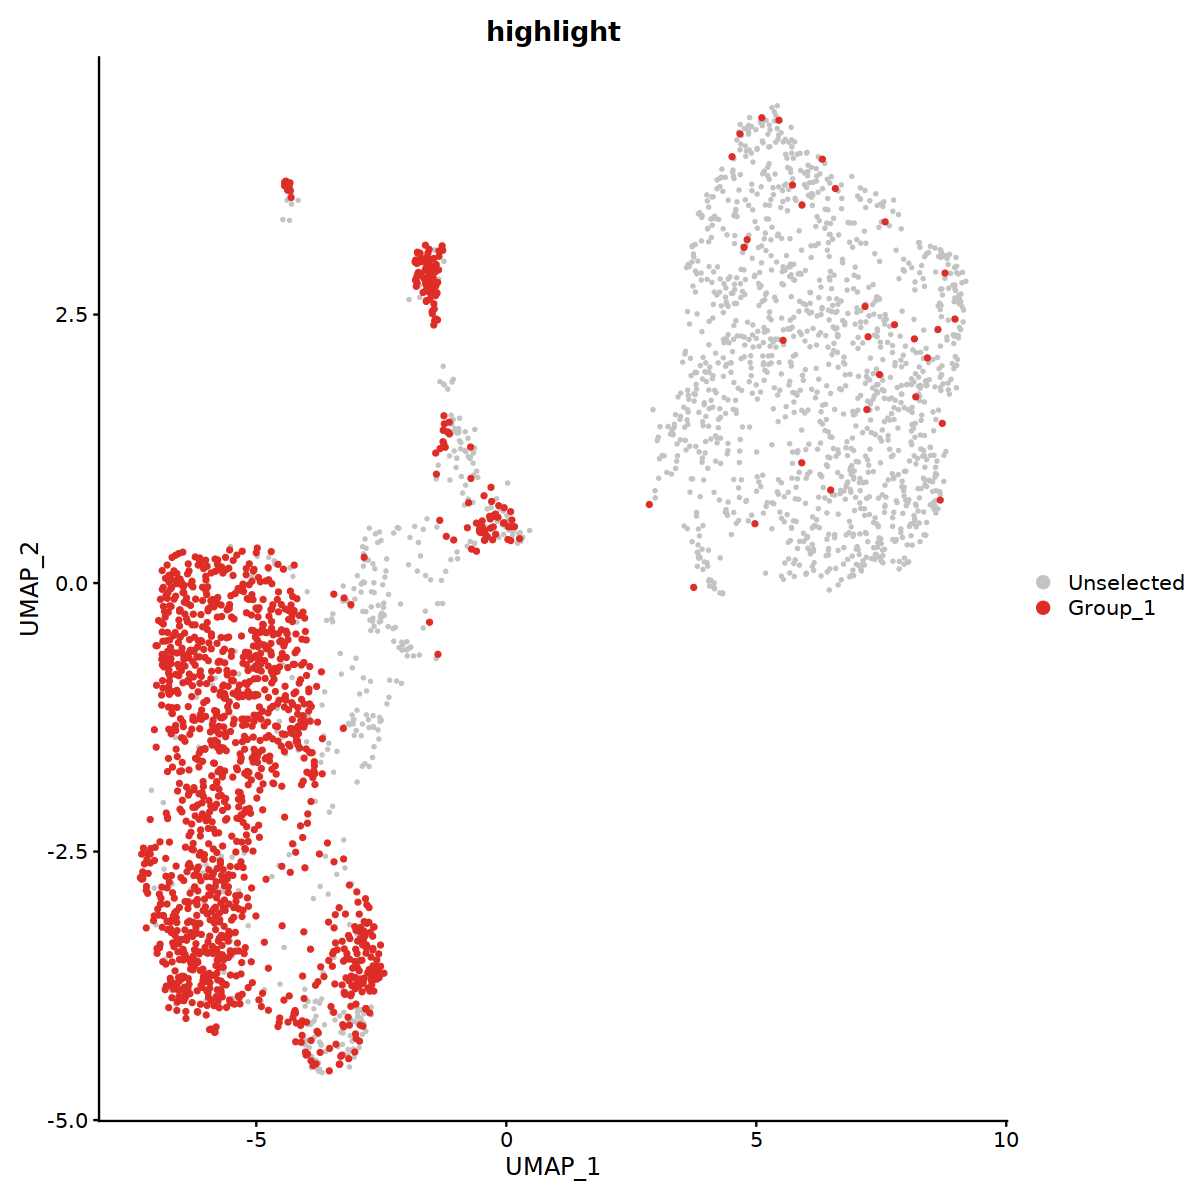

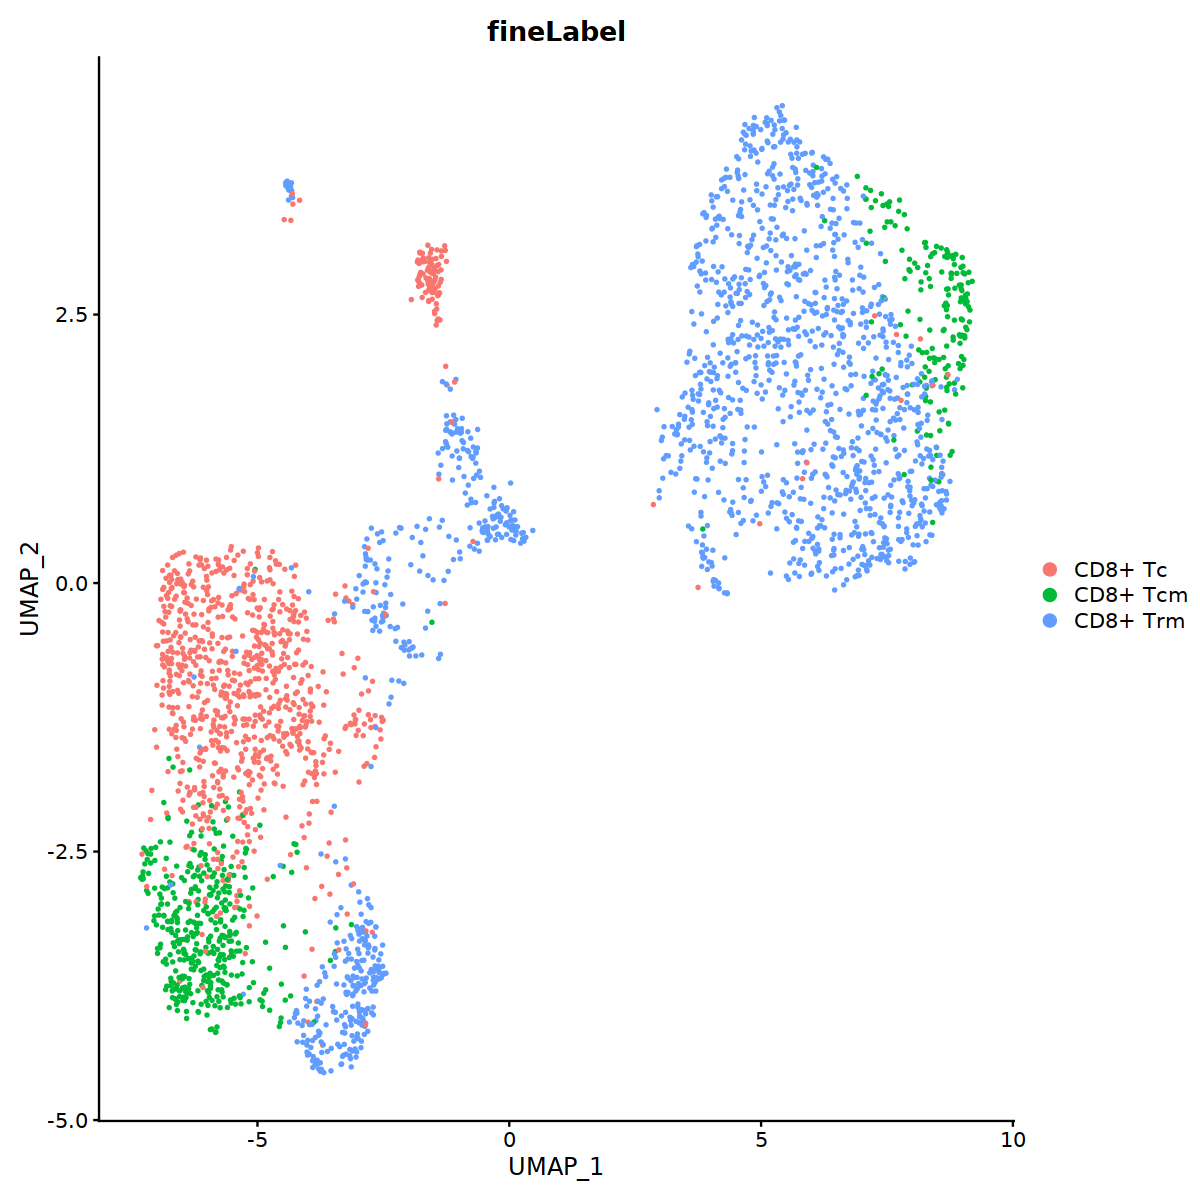